In [1]:
import os 
import numpy as np 
import random 
from PIL import Image, ImageEnhance 
#keras 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout,Input, Flatten 
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications import VGG16 
from sklearn.utils import shuffle 


In [3]:
train_dir = "C:\\Users\\YOGA\\OneDrive\\Desktop\\Documents\\ML\\Brain_Tumor_Deep_Learning_Project\\Brain_MRI_images\\Training"
test_dir  = "C:\\Users\\YOGA\\OneDrive\\Desktop\\Documents\\ML\\Brain_Tumor_Deep_Learning_Project\\Brain_MRI_images\\Testing"


In [5]:
#load and shuffle train data
train_paths=[]# for train images paths
train_labels=[] # for all image labels 

In [7]:
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)
train_paths,train_labels=shuffle(train_paths,train_labels,random_state=42)       

In [9]:
#all possible labels 
#glioma
# meningioma
# notumor
# pituitary

In [11]:
# load and shuffle test data 
test_paths=[]
test_labels=[] 
for label in os.listdir(test_dir): 
    for image in os.listdir(os.path.join(test_dir,label)): 
        test_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(label) 
test_paths,test_labels=shuffle(test_paths,test_labels,random_state=42)

# Data Visualization 

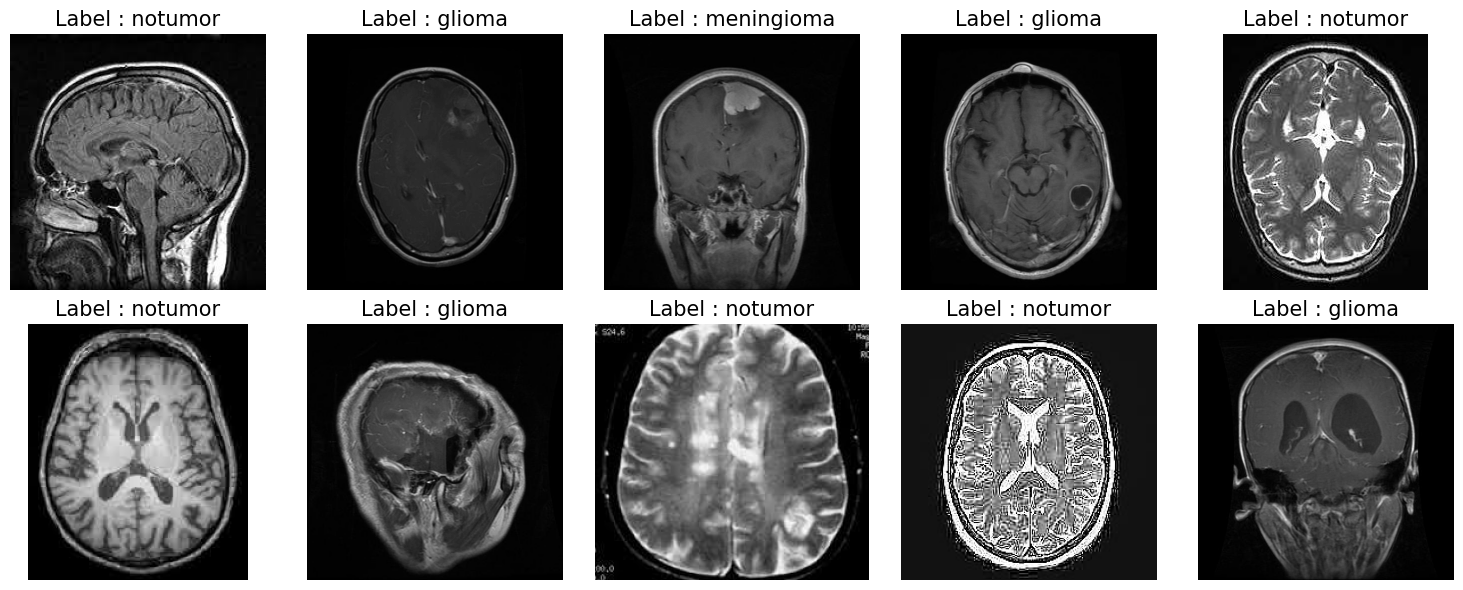

In [14]:
import matplotlib.pyplot as plt 
random_indices=random.sample(range(len(train_paths)),10)
fig,axes=plt.subplots(2,5,figsize=(15,6)) 
axes=axes.ravel()
for i,idx in enumerate(random_indices): 
    img_path=train_paths[idx]
    img=Image.open(img_path)
    axes[i].imshow(img,cmap='gray')
    axes[i].set_title(f'Label : {train_labels[idx]}',fontsize=15)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Image Preprocessing

In [17]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)
# Data generator for batching
def data_generator(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# MODEL:
## WE ARE USING VGG16 FOR TRANSFER LEARNING.
The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

- First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

- Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

- Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

- After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

- Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

- Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

- After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

- Next, another Dropout layer is added with model.add(Dropout(0.2))

- Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.

In [20]:
# Don't Run

In [22]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(data_generator(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - loss: 0.4607 - sparse_categorical_accuracy: 0.8239
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 846s 3s/step - loss: 0.2318 - sparse_categorical_accuracy: 0.9132
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - loss: 0.1682 - sparse_categorical_accuracy: 0.9368
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - loss: 0.1106 - sparse_categorical_accuracy: 0.9589
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 776s 3s/step - loss: 0.0751 - sparse_categorical_accuracy: 0.9738


# Train and Val Plots

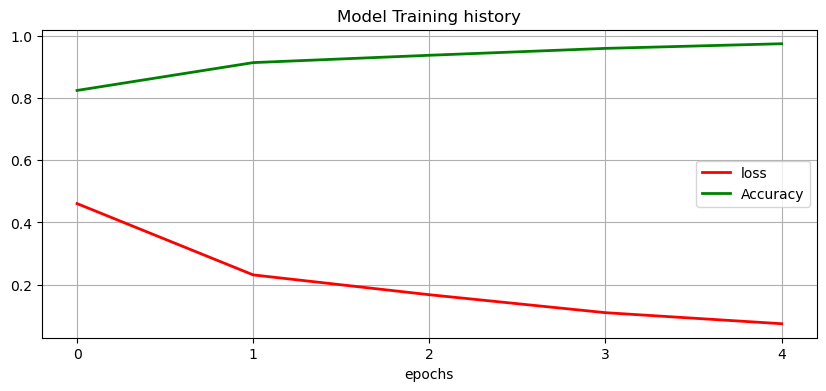

In [39]:
plt.figure(figsize=(10,4))
plt.grid(True)
plt.plot(history.history['loss'],'r-',linewidth=2)
plt.plot(history.history['sparse_categorical_accuracy'],'g-',linewidth=2)
plt.title('Model Training history')
plt.xlabel('epochs')
plt.xticks([i for i in range(epochs)])
plt.legend(['loss','Accuracy'],loc='center right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [47]:
test_images=open_images(test_paths)
test_labels_encoded=encode_label(test_labels)
test_predictions=model.predict(test_images)

41/41 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step


In [49]:
#classification_report
print(classification_report(test_labels_encoded,np.argmax(test_predictions,axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       300
           1       0.93      0.91      0.92       306
           2       0.99      1.00      0.99       405
           3       0.95      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



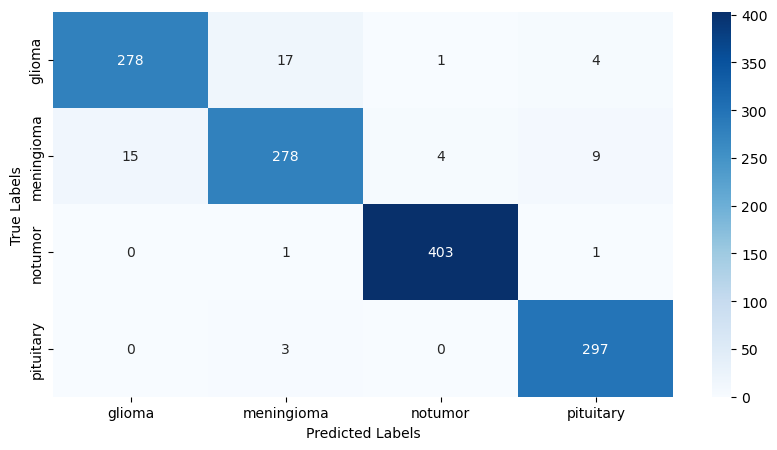

In [61]:
# coconfusion_matrix 
conf_matrix=confusion_matrix(test_labels_encoded,np.argmax(test_predictions,axis=1))
plt.figure(figsize=(10,5))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=os.listdir(train_dir),
            yticklabels=os.listdir(train_dir))

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


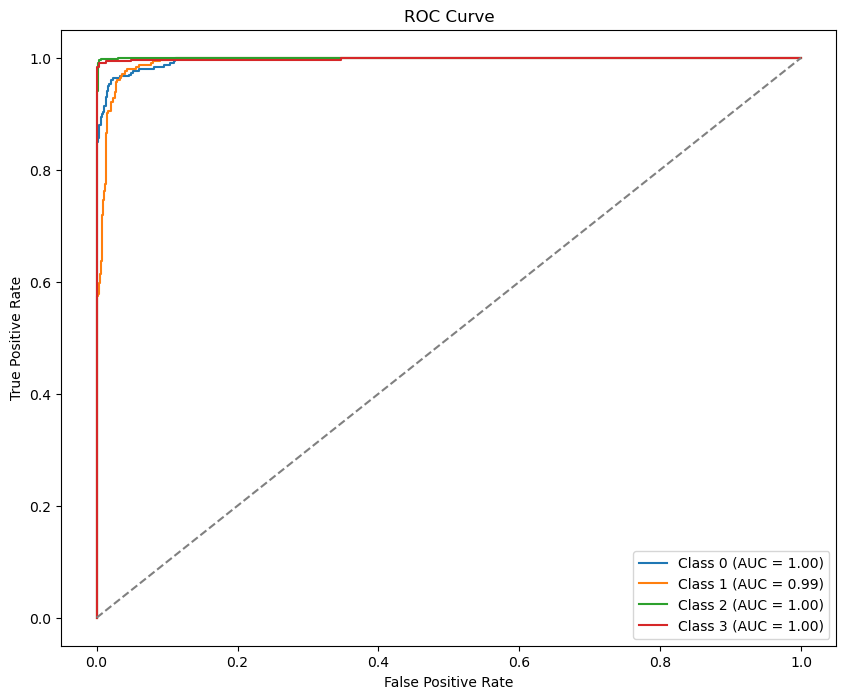

In [63]:
# roc plot and auc
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# save and Load Model

In [65]:
model.save('my_model.keras')

In [ ]:
# will have to retrain before visualizing

In [ ]:
# Run after this

In [67]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('my_model.keras')

In [83]:
from keras.preprocessing.image import img_to_array
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(image_path, model):
    try: 
        # Load and preprocess image
        img = load_img(image_path, target_size=(128,128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0   # normalize if model trained with normalization

        # Prediction
        prediction = model.predict(img_array)  # shape: (1,4)
        confidence_score = np.max(prediction, axis=1)[0] 
        predicted_class_index = np.argmax(prediction, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display image with prediction
        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


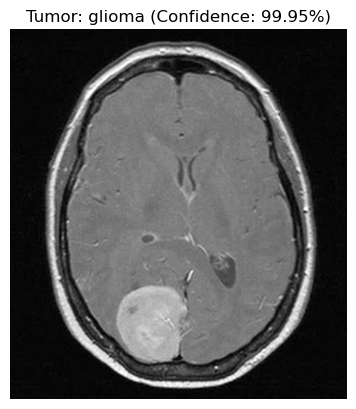

In [85]:
#example useage 
# Example usage
image_path = 'Brain_MRI_images/Testing/meningioma/Te-me_0010.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)